<a href="https://colab.research.google.com/github/AbdullaK123/E8cknEJX6iPLxUqM/blob/main/best_canditates_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Potential Talents

## Introduction

In this project, we will build a machine learning pipeline to automate canditate selection for a talent sourcing and management company. To accomplish this, we will fine tune a sentence transformer on our dataset of canditate profiles, and then use them to generate doc embeddings with which we will calculate a fitness score we can use to rank every canditate. After the initial ranking, we will then use a learning-to-rank model, namely Lambda Rank and Rank Net, to re-rank canditates should a reviewer choose to star a canditate.


## The Data

Our data is a csv file with the following data dictionary:

Attributes:
- id : the unique identifier for every candidate (numeric)

- job_title : the canditates job title (text)

- location : where the canditate is located (text)

- connections: how many connections the canditate has (500+ means over 500 connections) (text)

Output (desired target):
- fit - each canditates fitness score for the role (numeric, probability between 0-1)

Now, let us inspect our data and perform any necessary preprocessing before training any of our models.

## Data Preprocessing

First, let us install any necessary libraries.

In [3]:
# install needed libraries
!pip install sentence-transformers
!pip install datasets
!pip install transformers[torch]
!pip install accelerate -U

Now, let us mount our google drive for easy access to our data, and then glance at it's first five rows.

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util, InputExample, losses
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import wordcloud
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/content/drive/MyDrive/Project 3 Data/potential-talents - Aspiring human resources - seeking human resources.csv', index_col='id')

data.head()

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Kanada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 1 to 104
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   job_title   104 non-null    object 
 1   location    104 non-null    object 
 2   connection  104 non-null    object 
 3   fit         0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 4.1+ KB


In [7]:
data.duplicated().sum()

51

We see that our dataset is very small with quite a few duplicate entries. However, we will not remove these duplicates because two distinct canditates can have identical job profiles.

In [8]:
for col in data.columns:
  print("*"*50 + " " + col + " " + "*"*50 + "\n")
  print(data[col].unique())
  print("\n")

************************************************** job_title **************************************************

['2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional'
 'Native English Teacher at EPIK (English Program in Korea)'
 'Aspiring Human Resources Professional'
 'People Development Coordinator at Ryan'
 'Advisory Board Member at Celal Bayar University'
 'Aspiring Human Resources Specialist'
 'Student at Humber College and Aspiring Human Resources Generalist'
 'HR Senior Specialist'
 'Seeking Human Resources HRIS and Generalist Positions'
 'Student at Chapman University'
 'SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR'
 'Human Resources Coordinator at InterContinental Buckhead Atlanta'
 'Aspiring Human Resources Management student seeking an internship'
 'Seeking Human Resources Opportunities'
 'Experienced Retail Manager and aspiring Human Resources Professional'
 

We see that some of the locations are in Turkish, not English. So for consitency, let us change them to English.

In [9]:
map = {
    'Kanada': 'Canada',
    'İzmir, Türkiye': 'Izmir, Turkey',
    'Amerika Birleşik Devletleri': 'United States of America'
}

data['location'] = data['location'].replace(map)

data['location'].unique()

array(['Houston, Texas', 'Canada', 'Raleigh-Durham, North Carolina Area',
       'Denton, Texas', 'Izmir, Turkey', 'Greater New York City Area',
       'San Francisco Bay Area', 'Greater Philadelphia Area',
       'Lake Forest, California', 'Houston, Texas Area',
       'Atlanta, Georgia', 'Chicago, Illinois', 'Austin, Texas Area',
       'Jackson, Mississippi Area', 'Greater Grand Rapids, Michigan Area',
       'Virginia Beach, Virginia', 'Monroe, Louisiana Area',
       'Greater Boston Area', 'San Jose, California',
       'New York, New York', 'Dallas/Fort Worth Area',
       'United States of America', 'Baton Rouge, Louisiana Area',
       'Myrtle Beach, South Carolina Area', 'Chattanooga, Tennessee Area',
       'Los Angeles, California', 'Highland, California',
       'Gaithersburg, Maryland', 'Baltimore, Maryland',
       'Milpitas, California', 'Greater Atlanta Area',
       'Greater Chicago Area', 'Torrance, California',
       'Long Beach, California', 'Bridgewater, Massachus

In [10]:
data.head()

,job_title,location,connection,fit
id,,,,
1,2019 C.T. Bauer College of Business Graduate (...,"Houston, Texas",85,NaN
2,Native English Teacher at EPIK (English Progra...,Canada,500+,NaN
3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
5,Advisory Board Member at Celal Bayar University,"Izmir, Turkey",500+,NaN


## Exploratory Data Analysis

Now that we have preprocessed our dataset, let us perform an exploratory data analysis, starting with a visualization of the tf-idf scores of each job title.

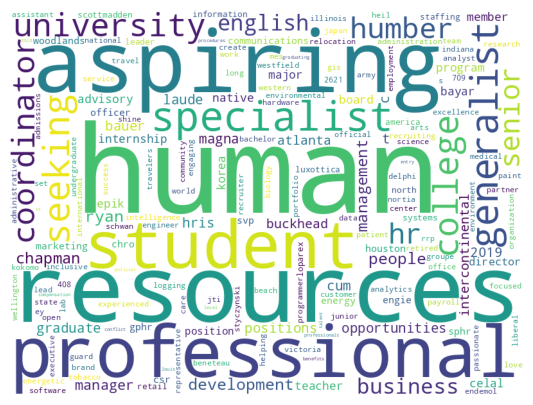

In [11]:
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    token_pattern=r'\b\w+\b'
)

tfidf_matrix = tfidf_vectorizer.fit_transform(data['job_title'])

wc = wordcloud.WordCloud(
    background_color='white',
    height=600,
    width=800
).generate_from_frequencies(
    dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.sum(axis=0).A1))
)

plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(wc)

From the word cloud above, we see that our dataset is heavily skewed toward HR canditates. Let us investigate further with a visualization of the counts of each word in our vocabulary.

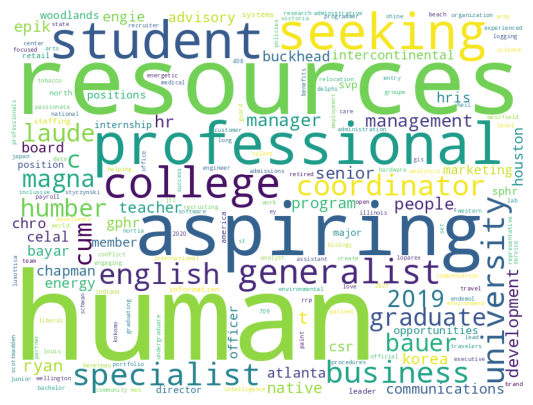

In [12]:
count_vectorizer = CountVectorizer(
    stop_words='english',
    token_pattern=r'\b\w+\b'
)

count_matrix = count_vectorizer.fit_transform(data['job_title'])

wc = wordcloud.WordCloud(
    background_color='white',
    height=600,
    width=800
).generate_from_frequencies(
    dict(zip(count_vectorizer.get_feature_names_out(), count_matrix.sum(axis=0).A1))
)

plt.figure(figsize=(10, 5))
plt.axis('off')
plt.imshow(wc)

Just like the previous word cloud, the one above confirms that our dataset is focused on human resources canditates. Let us plot the counts of the most common words in our vocabulary to investigate even further.

In [13]:
import plotly.io as pio

pio.templates.default = "ggplot2"

word_counts = pd.DataFrame({
    'word': count_vectorizer.get_feature_names_out(),
    'count': count_matrix.sum(axis=0).A1
})


fig = px.bar(
    x=word_counts.sort_values('count')['count'][-10:],
    y=word_counts.sort_values('count')['word'][-10:],
    color=word_counts.sort_values('count')['count'][-10:],
    color_continuous_scale='Viridis',
    orientation='h',
    title='Top 10 Most Common Words'
)

fig.update_layout(
    xaxis_title='Count',
    yaxis_title='Word'
)

fig.show()

From the plot above, we see that our dataset is not only focused on HR canditates, but on those with less experience given the key words *aspiring*, *student*, or *college*.

## Fine Tuning our Sentence Transformer

Now that we have explored our dataset, let us fine tune the Flan T5 sentence transformer on our data to obtain high quality embedding vectors for our initial ranking.

First, we must prepare our sentence pair dataset with every unique pair of job titles and their respective cosine similarity. And we will freeze all but the last three layers of our sentence transformer to prepare it for fine tuning.

In [14]:
from itertools import combinations
from gensim.utils import simple_preprocess

profiles = data['job_title'].tolist()

profiles = [" ".join(simple_preprocess(profile)) for profile in profiles]

profile_pairs = list(combinations(profiles, 2))

profile_pairs = set(profile_pairs) - set([pair for pair in profile_pairs if pair[0] == pair[1]])

profile_pairs

{('aspiring human resources specialist',
  'bachelor of science in biology from victoria university of wellington'),
 ('advisory board member at celal bayar university',
  'lead official at western illinois university'),
 ('bauer college of business graduate magna cum laude and aspiring human resources professional',
  'always set them up for success'),
 ('svp chro marketing communications csr officer engie houston the woodlands energy gphr sphr',
  'always set them up for success'),
 ('retired army national guard recruiter office manager seeking position in human resources',
  'human resources management major'),
 ('hr senior specialist', 'human resources management major'),
 ('advisory board member at celal bayar university',
  'native english teacher at epik english program in korea'),
 ('hr manager at endemol shine north america',
  'admissions representative at community medical center long beach'),
 ('aspiring human resources professional passionate about helping to create an inc

In [15]:
model = SentenceTransformer('sentence-transformers/sentence-t5-base')

for name, param in list(model.named_parameters())[:-3]:
  param.requires_grad = False

profile_embeddings = model.encode(profiles, convert_to_tensor=True)

similarity_scores = []

for profile_1, profile_2 in profile_pairs:
  embedding_1 = profile_embeddings[profiles.index(profile_1)]
  embedding_2 = profile_embeddings[profiles.index(profile_2)]
  similarity = util.pytorch_cos_sim(embedding_1, embedding_2)
  similarity_scores.append(similarity.item())

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/1.98k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/219M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/115 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

rust_model.ot:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

To prepare our data for fine tuning, let us shuffle it and then split it into training and test sets.

In [16]:
import random

pairs_data = list(zip(profile_pairs, similarity_scores))

random.shuffle(pairs_data)

split_ratio = 0.8
split_idx = int(len(data)*split_ratio)

train_data = pairs_data[:split_idx]
test_data = pairs_data[split_idx:]

train_pairs, train_similarities = zip(*train_data)
test_pairs, test_similarities = zip(*test_data)


Now, let us input our training and test sets into custom sentence pair datasets, and then input each into pytorch dataloaders.

In [17]:
class SentencePairDataset(Dataset):
  def __init__(self, pairs, similarities):
    self.pairs = pairs
    self.similarities = similarities

  def __len__(self):
    return len(self.pairs)

  def __getitem__(self, idx):
    profile_1, profile_2 = self.pairs[idx]
    similarity = self.similarities[idx]
    return InputExample(
        texts=[profile_1, profile_2],
        label=similarity
    )

train_dataset = SentencePairDataset(train_pairs, train_similarities)
test_dataset = SentencePairDataset(test_pairs, test_similarities)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [18]:
from datasets import Dataset

train_loss = losses.CosineSimilarityLoss(model)

model.fit(
    train_objectives=[(train_loader, train_loss)],
    epochs=10,
    optimizer_params={'lr': 1e-5},
    show_progress_bar=True
)

Step,Training Loss


Now that we have fine tuned our model, let us evaluate it.

In [19]:
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator
from sentence_transformers import evaluation

evaluator = EmbeddingSimilarityEvaluator.from_input_examples(test_dataset, batch_size=32, name='test')

model.evaluate(evaluator)

{'test_pearson_cosine': 0.9999999982826583,
 'test_spearman_cosine': 0.999999877324743,
 'test_pearson_manhattan': 0.9919181251294782,
 'test_spearman_manhattan': 0.9970049614698078,
 'test_pearson_euclidean': 0.9936347412415067,
 'test_spearman_euclidean': 0.9999998619903385,
 'test_pearson_dot': 0.9999999982980234,
 'test_spearman_dot': 0.9999998667086167,
 'test_pearson_max': 0.9999999982980234,
 'test_spearman_max': 0.999999877324743}

We see that our sentence transformer has achieved nearly start of the art performance on our dataset. Now that we have fine tuned our model, let us use it to generate high quality embeddings we will need for the next step of our problem -- reranking matches to a given query.

## Reranking with LightGBM and LambaRank

First, let us define our new embeddings and then define a function to wrangle our data into a shape suitable for our light gradient boosting model with LambdaRank loss and NDCG (Normalized Discounted Cummulative Gain) as our evaluation metric.

<Axes: >

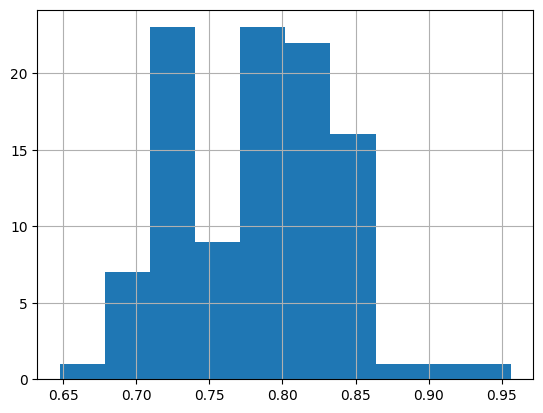

In [20]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import torch
import re

device = 'cuda' if torch.cuda.is_available() else 'cpu'

new_profile_embeddings = model.encode(profiles, convert_to_tensor=True)

def prepare_ranking_data(model, starred_canditate_id, query="Aspiring human resources"):

  ranking_data = pd.DataFrame()

  ########### similarities
  query = " ".join(simple_preprocess(query))
  query_embedding = model.encode(query, convert_to_tensor=True)
  ranking_data['query_similarities'] = util.pytorch_cos_sim(new_profile_embeddings, query_embedding).cpu().numpy().flatten()

  ############ location
  ohe = OneHotEncoder()

  locations_ohe = ohe.fit_transform(data[['location']])

  ranking_data = pd.concat([ranking_data, pd.DataFrame(locations_ohe.toarray(), columns=ohe.get_feature_names_out())], axis=1)

  ############ connections

  min_max_scaler = MinMaxScaler()

  connections = data['connection'].str.replace('+ ', "").astype(float).values

  ranking_data['connections'] = min_max_scaler.fit_transform(connections.reshape(-1, 1))


  ########### canditate similarities

  starred_canditate_embedding = new_profile_embeddings[starred_canditate_id]
  starred_canditate_location = ohe.transform([[data.loc[starred_canditate_id, 'location']]])
  starred_canditate_connections = ranking_data.iloc[starred_canditate_id]['connections']
  starred_canditate_feature_vector = np.concatenate(
      [
          0.7*starred_canditate_embedding.cpu().numpy(),
          0.15*starred_canditate_location.toarray().flatten(),
          0.15*np.array([starred_canditate_connections])
      ]
  ) # this will be the feature vector for which we will compare all others

  feature_vectors = [] # all other feature vectors

  for i, embedding in enumerate(new_profile_embeddings):
    location_vector = ohe.transform([[data.iloc[i]['location']]])
    connections_vector = ranking_data.iloc[i]['connections']
    feature_vector = np.concatenate(
        [
            0.7*embedding.cpu().numpy(),
            0.15*location_vector.toarray().flatten(),
            0.15*np.array([connections_vector])
        ]
    )
    feature_vectors.append(feature_vector)

  feature_vectors = np.array(feature_vectors)

  # cosine similarities between starred canditate feature vector and all others
  ranking_data['canditate_similarities'] = util.pytorch_cos_sim(torch.tensor(feature_vectors), torch.tensor(starred_canditate_feature_vector)).cpu().numpy()

  ########### group

  ranking_data = ranking_data.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

  ranking_data['group'] = 1

  return ranking_data

## we will be starring the canditate with the id 99 as an example.
ranking_data = prepare_ranking_data(model, 99)

ranking_data['canditate_similarities'].hist()

From the histogram above, we see that most samples have a cosine similarity below `0.85`. Let us use this as a threshold for the binary target column we will define.

In [21]:
from sklearn.model_selection import StratifiedKFold, KFold

X = ranking_data.drop('canditate_similarities', axis=1)
y = (ranking_data['canditate_similarities'] > 0.85).astype(int) # binary target col for ranking

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_data = lgb.Dataset(X_train, label=y_train, group=[X_train.shape[0]])
val_data = lgb.Dataset(X_val, label=y_val, group=[X_val.shape[0]])

kf = KFold(n_splits=5, shuffle=True, random_state=42)

params = {
    'boosting_type': 'gbdt',
    'objective': 'lambdarank',
    'metric': 'ndcg',
    'num_iterations': 5,
    'learning_rate': 0.1,
    'num_leaves': 2,
    'max_depth': 2,
    'eval_at': [3, 5, 10],
    'min_data_in_leaf': 10,
    'verbosity': 1
}

bst = lgb.cv(
    params,
    train_set=lgb.Dataset(X, label=y, group=[X.shape[0]]),
    return_cvbooster=True,
    folds=kf
)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 42
[LightGBM] [Info] Number of data points in the train set: 83, number of used features: 3
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0

In [22]:
from sklearn.metrics import ndcg_score

print(np.array(bst['valid ndcg@10-mean']).mean())
print(np.array(bst['valid ndcg@5-mean']).mean())
print(np.array(bst['valid ndcg@3-mean']).mean())

0.8256592551757826
0.7425963661214157
0.7580176825250173


We see that after training our lgbm model with cross validation for robust results we obtain exceptional ndcg scores for our re-ranking. Let us now explore an alternative approach using the RankNet architecture.

## Reranking with RankNet

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, activations, losses, Model, Input
from tensorflow.nn import leaky_relu
import numpy as np
from itertools import combinations
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# model architecture
class RankNet(Model):
    def __init__(self, input_shape):
        super().__init__()
        self._input_shape = input_shape
        self.dense = [
            layers.Dense(256, activation=leaky_relu),
            layers.Dropout(0.5),
            layers.Dense(256, activation=leaky_relu),
            layers.Dropout(0.5),
        ]
        self.o = layers.Dense(1, activation='linear')
        self.oi_minus_oj = layers.Subtract() # RankNet works by applying sigmoid activation to the difference between two feature vectors representing each pair of docs

    def call(self, inputs):
        xi, xj = inputs
        densei = self.dense[0](xi)
        densej = self.dense[0](xj)
        for dense in self.dense[1:]:
            densei = dense(densei)
            densej = dense(densej)
        oi = self.o(densei)
        oj= self.o(densej)
        oij = self.oi_minus_oj([oi, oj])
        output = layers.Activation('sigmoid')(oij)
        return output

    def build_graph(self):
        x = [Input(shape=self._input_shape), Input(shape=self._input_shape)]
        return Model(inputs=x, outputs=self.call(x))

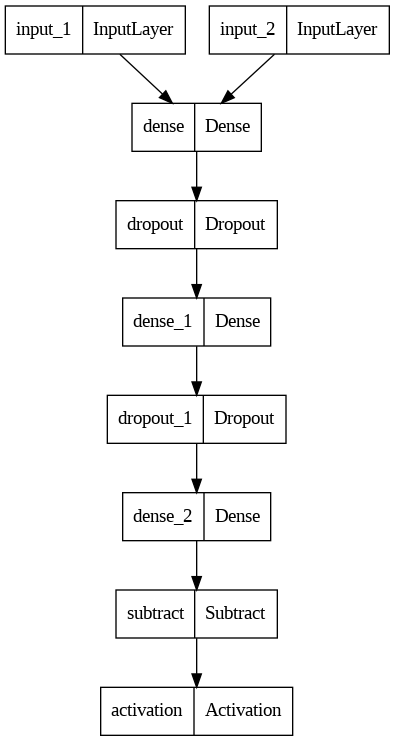

In [24]:
plot_model(RankNet(input_shape=(50)).build_graph(), show_shapes=False)

Now that we have built the RankNet architecture, let us wrangle our data into a suitable format for training.

In [25]:
from itertools import combinations

threshold = 0.2
doc_features = ranking_data.drop(['canditate_similarities', 'group'], axis=1).values
doc_scores = ranking_data['canditate_similarities'].values # we will use this column to measure doc relevance

doc_pairs = list(combinations(range(len(ranking_data)), 2))

# RankNet needs unique pairs of docs (i.e. features) and a binary target indicating which doc is more relevant.
xi = np.array([doc_features[pair[0]] for pair in doc_pairs])
xj = np.array([doc_features[pair[1]] for pair in doc_pairs])
# here the threshold ensures our model only learns meaningful differences in relevance between docs
pij = np.array([1 if doc_scores[pair[0]] > doc_scores[pair[1]] + threshold else 0 for pair in doc_pairs])

# splitting our data into training and test sets
xi_train, xi_test, xj_train, xj_test, pij_train, pij_test = train_test_split(
    xi, xj, pij, test_size=0.2, random_state=42
)

# the number of doc pairs in which the first doc is more relevant
pij_train.sum()

8

In [26]:
from tensorflow.keras.optimizers import Adam, RMSprop

rank_net = RankNet(input_shape=(xi_train.shape[1]))
rank_net.compile(
    optimizer='adam',
    loss='binary_crossentropy'
)
rank_net.fit(
    [xi_train, xj_train],
    pij_train,
    epochs=50,
    batch_size=32,
    validation_data=(
        [xi_test, xj_test],
        pij_test
    )
)

Epoch 1/50
134/134 [==============================] - 4s 13ms/step - loss: 0.5299 - val_loss: 0.4150
Epoch 2/50
134/134 [==============================] - 1s 6ms/step - loss: 0.4275 - val_loss: 0.3884
Epoch 3/50
134/134 [==============================] - 1s 7ms/step - loss: 0.4109 - val_loss: 0.3797
Epoch 4/50
134/134 [==============================] - 1s 6ms/step - loss: 0.4005 - val_loss: 0.3732
Epoch 5/50
134/134 [==============================] - 1s 6ms/step - loss: 0.3893 - val_loss: 0.3699
Epoch 6/50
134/134 [==============================] - 1s 6ms/step - loss: 0.3833 - val_loss: 0.3666
Epoch 7/50
134/134 [==============================] - 1s 6ms/step - loss: 0.3844 - val_loss: 0.3670
Epoch 8/50
134/134 [==============================] - 1s 6ms/step - loss: 0.3861 - val_loss: 0.3651
Epoch 9/50
134/134 [==============================] - 1s 6ms/step - loss: 0.3763 - val_loss: 0.3631
Epoch 10/50
134/134 [==============================] - 1s 6ms/step - loss: 0.3812 - val_loss: 0.360

In [27]:
from sklearn.metrics import ndcg_score

y_scores = rank_net.predict([xi_test, xj_test]).reshape(1, -1)
y_true = pij_test.reshape(1, -1)

ndcg_score(y_true, y_scores, k=10)

34/34 [==============================] - 0s 2ms/step


0.5531464700081437

Our results are not as good as those we obtained from the LambdaRank light gradient boosting machine. However, with further fine tuning, or tweaking of the model architecture, we can obtain better results.

Now, let us explore an alternative approach to our problem using Large Language Models and prompt engineering.

## Using the OpenAI API and HuggingFaceHub

First, let us install the openai library.

In [28]:
!pip install openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.5/328.5 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.9 MB/s eta 0:00:00


In [29]:
from openai import OpenAI
from google.colab import userdata

client = OpenAI(api_key=userdata.get("OPEN_AI_KEY"))

query = "Aspiring human resources"

prompt = f"""I want you take the following query: {query}, and this list of canditates: {profiles}, then
             give me the top 10 canditates most similar to the query. If no matches can be found, then respond with 'I don't know'.
             And if two canditates have the same job title, please pick one of them."""

chat_history = []

response = client.chat.completions.create(
    model="gpt-4o",
    temperature=0,
    messages=[
        {"role": "system", "content": "You are a HR professional with decades of experience working for Fortune 500 companies."},
        {"role": "user", "content": prompt}
    ]
)

response_message = response.choices[0].message.content
chat_history.append({"role": "system", "content": "You are a HR professional with decades of experience working for Fortune 500 companies."})
chat_history.append({"role": "user", "content": prompt})
chat_history.append({"role": "assistant", "content": response_message})
print(response_message)

Based on the query "Aspiring human resources," here are the top 10 candidates most similar to the query, ensuring no duplicate job titles:

1. **Aspiring human resources professional**
2. **Aspiring human resources specialist**
3. **Student at Humber College and aspiring human resources generalist**
4. **Aspiring human resources management student seeking an internship**
5. **Seeking human resources opportunities**
6. **Aspiring human resources manager seeking internship in human resources**
7. **Aspiring human resources professional passionate about helping to create an inclusive and engaging work environment**
8. **Liberal arts major aspiring human resources analyst**
9. **Aspiring human resources professional an energetic and team focused leader**
10. **Business management major and aspiring human resources manager**

These candidates are selected based on their explicit mention of aspirations in the human resources field.


In [30]:
prompt = """I want to star the 7th canditate on your list. Now rerank your list such that
            the starred canditate is at the top and the others are ordered from most to least
            similar to the starred canditate."""

chat_history.append({"role": "user", "content": prompt})

response = client.chat.completions.create(
    model="gpt-4o",
    temperature=0,
    messages=chat_history
)

response_message = response.choices[0].message.content
chat_history.append({"role": "assistant", "content": response_message})
print(response_message)

Sure, here is the reranked list with the starred candidate at the top and the others ordered from most to least similar to the starred candidate:

1. **Aspiring human resources professional passionate about helping to create an inclusive and engaging work environment** (Starred)
2. **Aspiring human resources professional an energetic and team focused leader**
3. **Aspiring human resources professional**
4. **Aspiring human resources specialist**
5. **Aspiring human resources management student seeking an internship**
6. **Aspiring human resources manager seeking internship in human resources**
7. **Student at Humber College and aspiring human resources generalist**
8. **Liberal arts major aspiring human resources analyst**
9. **Business management major and aspiring human resources manager**
10. **Seeking human resources opportunities**

This ranking prioritizes candidates who emphasize their passion, energy, and focus on creating an inclusive and engaging work environment, similar to 

We see that prompt engineering has yielded excellent results. Now, let us try the same with the Mistral open source LLM. To interact with it, we will use the langchain library, along with HuggingFaceHub.

In [31]:
!pip install langchain
!pip install langchain_community

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 987.6/987.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.5/366.5 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.1/141.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.2/49.2 kB 5.9 MB/s eta 0:00:00


In [35]:
from langchain import HuggingFaceHub, PromptTemplate, LLMChain
from langchain.chains import ConversationChain

llm = HuggingFaceHub(
    repo_id="mistralai/Mistral-7B-Instruct-v0.3",
    huggingfacehub_api_token=userdata.get("HF_TOKEN"),
    model_kwargs = {
        'max_new_tokens': 20000,
        'temperature': 0.1,
    }
)

conversation = ConversationChain(llm=llm, verbose=True) # the conversation chain will allow our llm to remember previous prompts and reponses to them

query = "Aspiring human resources"

prompt_1 = f"""
**Task:** You are an experienced HR professional. Your goal is to find the most suitable candidates for a given search query.

**Search query:** {query}

**Candidate Profiles:**

{profiles}

**Instructions:**

1. Carefully analyze each candidate profile in relation to the search query.
2. Identify the top 10 candidates whose job titles align most closely, semantically, with the search query.
3. If two candidates have identical job titles, select only one.
4. If you cannot find suitable candidates, simply respond with "No suitable candidates found."
5. Present your findings as an ordered list of the top 10 candidate names, ranked from most to least suitable.

**Results:**
"""

result = conversation.predict(input=prompt_1)

print(result)



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:

Human: 
**Task:** You are an experienced HR professional. Your goal is to find the most suitable candidates for a given search query.

**Search query:** Aspiring human resources

**Candidate Profiles:**

['bauer college of business graduate magna cum laude and aspiring human resources professional', 'native english teacher at epik english program in korea', 'aspiring human resources professional', 'people development coordinator at ryan', 'advisory board member at celal bayar university', 'aspiring human resources specialist', 'student at humber college and aspiring human resources generalist', 'hr senior specialist', 'student at humber college and aspiring human reso

In [33]:
prompt_2 = """I want to star the 7th canditate on your list. Now rerank your list such that the starred canditate
is at the top and the remaining candidates are arranged from most to least similar to the starred canditate.
"""

result = conversation.predict(input=prompt_2)
print(result)



> Entering new ConversationChain chain...
Prompt after formatting:
The following is a friendly conversation between a human and an AI. The AI is talkative and provides lots of specific details from its context. If the AI does not know the answer to a question, it truthfully says it does not know.

Current conversation:
Human: 
**Task:** You are an experienced HR professional. Your goal is to find the most suitable candidates for a given search query.

**Search query:** Aspiring human resources

**Candidate Profiles:**

['bauer college of business graduate magna cum laude and aspiring human resources professional', 'native english teacher at epik english program in korea', 'aspiring human resources professional', 'people development coordinator at ryan', 'advisory board member at celal bayar university', 'aspiring human resources specialist', 'student at humber college and aspiring human resources generalist', 'hr senior specialist', 'student at humber college and aspiring human resou